In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.style.use('~/line_plot.mplstyle')

import json, os, pickle
from scipy.signal import argrelmin
from scipy.optimize import curve_fit
from pathlib import Path

C6 = 2 * np.pi * .862690

In [2]:
def generate_sites_lieb_lattice(n_x, n_y, include_last_column=True):
    # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
    sites = []

    x_ind = 0
    y_ind = 0

    for ii in range(n_x):
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

        x_ind += 1
        y_ind -= 1

        for jj in range(n_y):
            sites.append([x_ind, y_ind])
            y_ind -= 2

        y_ind += 1

    if include_last_column:
        x_ind += 1

        for jj in range(n_y):
            y_ind += 1
            sites.append([x_ind, y_ind])
            y_ind += 1
            sites.append([x_ind, y_ind])

    return sites

def calculate_binder_cumulant(exp_op_2, exp_op_4):
    return 3 / 2 - exp_op_4 / (exp_op_2 ** 2) / 2

def calculate_susceptibility(n_sites, op, exp_op_2):
    return n_sites * (exp_op_2 - op ** 2)

def star_op(n_x, n_y, rydberg_density):
    sites = generate_sites_lieb_lattice(n_x, n_y)
    
    def manual_ft(density, sites, k):
        N = len(density)

        x = np.array(sites)[:, 0]
        y = np.array(sites)[:, 1]

        phase_1 = np.exp(1j * k[0] * x)
        phase_2 = np.exp(1j * k[1] * y)

        return np.sum(np.multiply(phase_1, np.multiply(phase_2, density))) / np.sqrt(N)
    
    return np.abs(manual_ft(rydberg_density, sites, (np.pi / 2, np.pi)))

def colinear_op(n_x, n_y, rydberg_density):
    sites = generate_sites_lieb_lattice(n_x, n_y)
    n_sites = len(sites)
    
    op = 0
    
    for ii in range(len(sites)):
        site = sites[ii]
        
        if site[0] % 2 == 1 and site[1] % 2 == 0:
            op += rydberg_density[ii]
        elif site[0] % 2 == 0 and site[1] % 2 == 1:
            op -= rydberg_density[ii]

    return op / n_sites

In [3]:
top_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/fss_colinear_2"

data_dir = top_dir + "/phase_diagram_data"

# data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/temp_data_dir/pinning_field_2"


f_names = os.listdir(data_dir)

n_ys = []
rbs = []
deltas = []

ops = []
exp_op_2s = []
exp_op_4s = []

for f_name in f_names:

    with open(Path(data_dir, f_name), 'r') as f:
        data_dict = json.load(f)

    density = data_dict["results"]["rydberg_density"]
    n_x = 2 * data_dict["params"]["ham_config"]["n_x"] + 1
    n_y = 2 * data_dict["params"]["ham_config"]["n_y"]
    n_ys.append(n_y)

    rbs.append(data_dict["params"]["ham_config"]["Rb"])
    deltas.append(data_dict["params"]["ham_config"]["delta"])

    ops.append(data_dict["results"]["op"])
    # ops.append(colinear_op(n_x, n_y, density))
    exp_op_2s.append(data_dict["results"]["exp_op_2"])
    exp_op_4s.append(data_dict["results"]["exp_op_4"])
    
# rb_over_a = rbs_over_a[0]
rb = rbs[0]

In [4]:
distinct_nys = []
for n_y in n_ys:
    if not n_y in distinct_nys:
        distinct_nys.append(n_y)

distinct_nys.sort()
distinct_nys = np.array(distinct_nys)

data = {}

for n_y in distinct_nys:
    data[n_y] = {}
    data[n_y]["deltas"] = []
    data[n_y]["op"] = []
    data[n_y]["exp_op_2"] = []
    data[n_y]["exp_op_4"] = []
    data[n_y]["U_4"] = []
    data[n_y]["chi"] = []

for ii, n_y in enumerate(n_ys):
    data[n_y]["deltas"].append(deltas[ii])
    data[n_y]["op"].append(ops[ii])
    data[n_y]["exp_op_2"].append(exp_op_2s[ii])
    data[n_y]["exp_op_4"].append(exp_op_4s[ii])
    data[n_y]["U_4"].append(calculate_binder_cumulant(exp_op_2s[ii], exp_op_4s[ii]))
    data[n_y]["chi"].append(calculate_susceptibility(3 * (2 * n_y) * (2 * 2 * n_y - 1), ops[ii], exp_op_2s[ii]))
    
for n_y in distinct_nys:
    data[n_y]["deltas"] = np.array(data[n_y]["deltas"])
    data[n_y]["op"] = np.array(data[n_y]["op"])
    data[n_y]["exp_op_2"] = np.array(data[n_y]["exp_op_2"])
    data[n_y]["exp_op_4"] = np.array(data[n_y]["exp_op_4"])
    data[n_y]["U_4"] = np.array(data[n_y]["U_4"])
    data[n_y]["chi"] = np.array(data[n_y]["chi"])
    
for n_y in distinct_nys:
    sort_inds = data[n_y]["deltas"].argsort()
    
    data[n_y]["deltas"] = data[n_y]["deltas"][sort_inds[::1]]
    data[n_y]["op"] = data[n_y]["op"][sort_inds[::1]]
    data[n_y]["exp_op_2"] = data[n_y]["exp_op_2"][sort_inds[::1]]
    data[n_y]["exp_op_4"] = data[n_y]["exp_op_4"][sort_inds[::1]]
    data[n_y]["U_4"] = data[n_y]["U_4"][sort_inds[::1]]
    data[n_y]["chi"] = data[n_y]["chi"][sort_inds[::1]]    

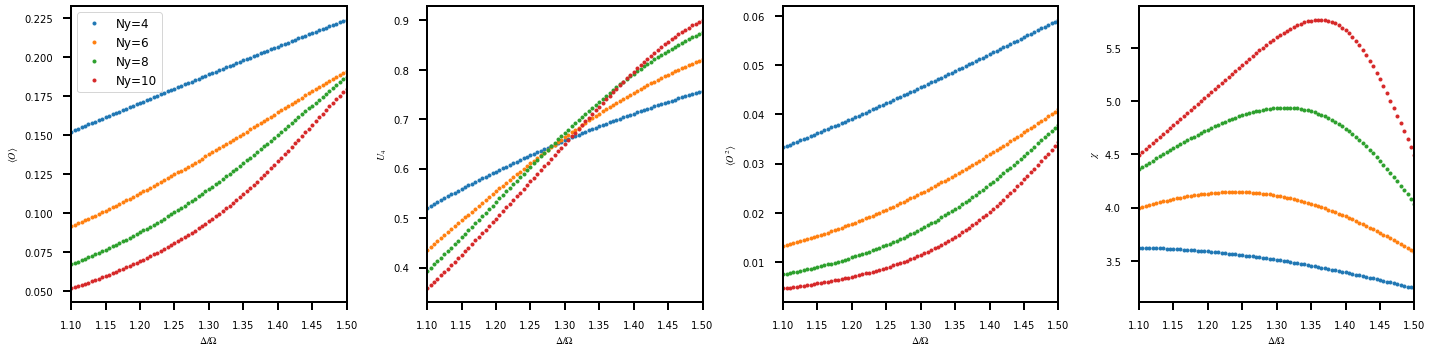

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for n_y in distinct_nys:
    x_ax = data[n_y]["deltas"]    
    
    axes[0].plot(x_ax, data[n_y]["op"], '.', label=f"Ny={n_y}")
    axes[0].set_ylabel(r"$\langle O \rangle$")
    
    axes[1].plot(x_ax, data[n_y]["U_4"], '.', label=f"Ny={n_y}")
    axes[1].set_ylabel(r"$U_4$")
    
    axes[2].plot(x_ax, data[n_y]["exp_op_2"], '.', label=f"Ny={n_y}")
    axes[2].set_ylabel(r"$\langle O^2 \rangle$")
    
    axes[3].plot(x_ax, data[n_y]["chi"], '.', label=f"Ny={n_y}")
    axes[3].set_ylabel(r"$\chi$")
    
axes[0].legend(fontsize=12)

for ax in axes:
    ax.set_xlabel(r"$\Delta/\Omega$")

plt.tight_layout()
plt.show()

In [6]:
intersections = []

for n_y in distinct_nys[:-1]:
    d_delta = data[n_y]["deltas"][1] - data[n_y]["deltas"][0]
    
    int_ind = np.diff(np.sign(data[n_y + 2]["U_4"] - data[n_y]["U_4"])).nonzero()[0][0]
    
    delta_0 = data[n_y]["deltas"][int_ind]
    
    y_a0 = data[n_y]["U_4"][int_ind]
    y_a1 = data[n_y]["U_4"][int_ind + 1]
    y_b0 = data[n_y + 2]["U_4"][int_ind]
    y_b1 = data[n_y + 2]["U_4"][int_ind + 1]
    
    intersections.append(delta_0 + d_delta * (y_a0 - y_b0) / (y_b1 - y_a1 + y_a0 - y_b0))
    
print(intersections)

[1.2860523488403002, 1.2719131018997594, 1.3852819197454362]


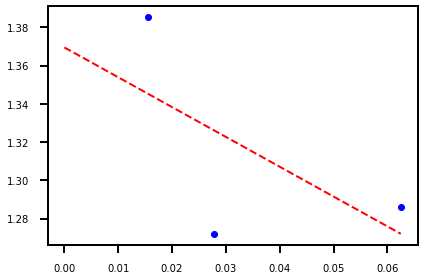

1.3694779522831038


In [7]:
def poly_fit(x, a, b):
    return [a + b * y for y in x]

popt, pcov = curve_fit(poly_fit, 1 / (distinct_nys[:-1] ** 2), intersections, (1.1, 0.1))

delta_c_extrap = popt[0]

x_ax = np.linspace(0, 1 / (distinct_nys[0] ** 2), 100)

plt.plot(x_ax, poly_fit(x_ax, popt[0], popt[1]), 'r--')
plt.plot(1 / (distinct_nys[:-1] ** 2), intersections, 'bo')

plt.margins(0.05)

plt.tight_layout()

plt.show()

print(delta_c_extrap)

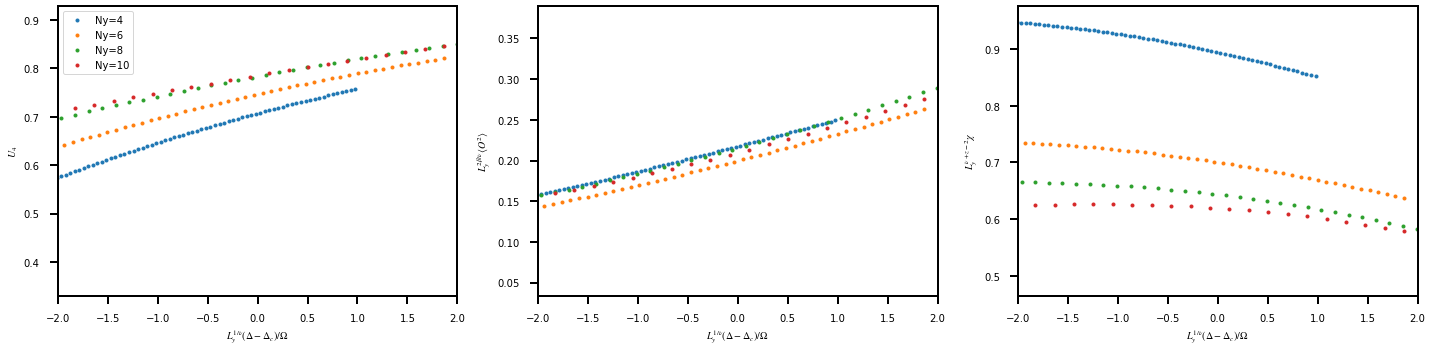

In [8]:
delta_c = delta_c_extrap
delta_c = 1.392

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

v = 0.629
beta = 0.326
eta = 0.036
z = 1.0

for n_y in distinct_nys:
    x_ax = (n_y ** (1 / v)) * (data[n_y]["deltas"] - delta_c)
    
    axes[0].plot(x_ax, data[n_y]["U_4"], '.', label=f"Ny={n_y}")
    axes[0].set_ylabel(r"$U_4$")
    
    axes[1].plot(x_ax, (n_y ** (2 * beta / v)) * data[n_y]["exp_op_2"], '.')
    axes[1].set_ylabel(r"$L_y^{2\beta/\nu}\langle O^2 \rangle$")
    
    axes[2].plot(x_ax, (n_y ** (eta + z - 2)) * data[n_y]["chi"], '.')
    axes[2].set_ylabel(r"$L_y^{\nu+z-2}\chi$")

for ax in axes:
    ax.set_xlabel(r"$L_y^{1/\nu}(\Delta - \Delta_c)/\Omega$")

# axes[0].set_ylim(0.0, 1.0)

x_range = 2.0
axes[0].set_xlim(-x_range, x_range)
axes[1].set_xlim(-x_range, x_range)
axes[2].set_xlim(-x_range, x_range)

# axes[0].set_ylim(0.65, 0.85)
# axes[1].set_ylim(0.12, 0.3)
# axes[2].set_ylim(0.57, 0.7)

axes[0].legend()

plt.tight_layout()
plt.show()